In [ ]:
import pandas as pd
from google.colab import files


uploaded = files.upload()
weather = pd.read_csv("weather.csv", index_col="DATE")

Saving weather.csv to weather.csv


In [ ]:
weather = pd.read_csv("weather.csv", index_col="DATE")
weather['TMAX'] = (2* weather['TAVG'])-weather['TMIN']
weather['PRCP'] = weather['PRCP'].fillna(0)
weather

,STATION,NAME,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,
2019-11-20,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,97.0,71.0
2019-11-21,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0
2019-11-22,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,97.0,73.0
2019-11-23,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,96.0,74.0
2019-11-24,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,96.0,72.0
...,...,...,...,...,...,...
2023-11-16,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0
2023-11-17,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0
2023-11-18,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0


In [ ]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
null_pct

STATION    0.00000
NAME       0.00000
PRCP       0.00000
TAVG       0.00000
TMAX       0.08499
TMIN       0.08499
dtype: float64

In [ ]:
valid_columns = weather.columns[null_pct < .10]
valid_columns

Index(['STATION', 'NAME', 'PRCP', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

In [ ]:
weather.columns = weather.columns.str.lower()

In [ ]:
weather = weather.ffill()
weather.apply(pd.isnull).sum()


station    0
name       0
prcp       0
tavg       0
tmax       0
tmin       0
dtype: int64

In [ ]:
weather.index = pd.to_datetime(weather.index)
weather.index.year.value_counts().sort_index()

2019     42
2020    366
2021    362
2022    365
2023    324
Name: DATE, dtype: int64

In [ ]:
weather["target"] = weather.shift(-1)["tavg"]
weather = weather.ffill()
weather

,station,name,prcp,tavg,tmax,tmin,target
DATE,,,,,,,
2019-11-20,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,97.0,71.0,85.0
2019-11-21,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0,85.0
2019-11-22,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,97.0,73.0,85.0
2019-11-23,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,96.0,74.0,84.0
2019-11-24,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,96.0,72.0,83.0
...,...,...,...,...,...,...,...
2023-11-16,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0,85.0
2023-11-17,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0,85.0
2023-11-18,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0,86.0


In [ ]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]


In [ ]:
predictors

Index(['prcp', 'tavg', 'tmax', 'tmin'], dtype='object')

In [ ]:
def backtest(weather, model, predictors, start=355, step=10):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(weather, rr, predictors)

In [ ]:
predictions

,actual,prediction,diff
DATE,,,
2020-11-09,82.0,84.877284,2.877284
2020-11-10,83.0,82.178855,0.821145
2020-11-11,82.0,83.099427,1.099427
2020-11-12,85.0,82.157759,2.842241
2020-11-13,86.0,84.940571,1.059429
...,...,...,...
2023-11-16,85.0,84.780553,0.219447
2023-11-17,85.0,84.774376,0.225624
2023-11-18,86.0,84.777961,1.222039


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

1.1824143757978922

In [ ]:
pd.Series(rr.coef_, index=predictors)


prcp    0.138165
tavg    0.896680
tmax    0.001462
tmin    0.005047
dtype: float64

In [ ]:
weather


,station,name,prcp,tavg,tmax,tmin,target
DATE,,,,,,,
2019-11-20,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,97.0,71.0,85.0
2019-11-21,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0,85.0
2019-11-22,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,97.0,73.0,85.0
2019-11-23,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,96.0,74.0,84.0
2019-11-24,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,84,96.0,72.0,83.0
...,...,...,...,...,...,...,...
2023-11-16,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0,85.0
2023-11-17,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,99.0,71.0,85.0
2023-11-18,IN012070800,"BOMBAY SANTACRUZ, IN",0.0,85,98.0,72.0,86.0


In [ ]:
weather = weather.iloc[10:,:]
weather = weather.fillna(0)

In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictions = backtest(weather, rr, predictors)

In [ ]:
predictions

,actual,prediction,diff
DATE,,,
2020-11-19,84.0,84.764698,0.764698
2020-11-20,83.0,83.907410,0.907410
2020-11-21,83.0,83.050122,0.050122
2020-11-22,83.0,83.050122,0.050122
2020-11-23,83.0,83.069968,0.069968
...,...,...,...
2023-11-16,85.0,84.776773,0.223227
2023-11-17,85.0,84.770600,0.229400
2023-11-18,86.0,84.774561,1.225439


In [ ]:
mean_absolute_error(predictions["actual"], predictions["prediction"])

1.1820313512364782

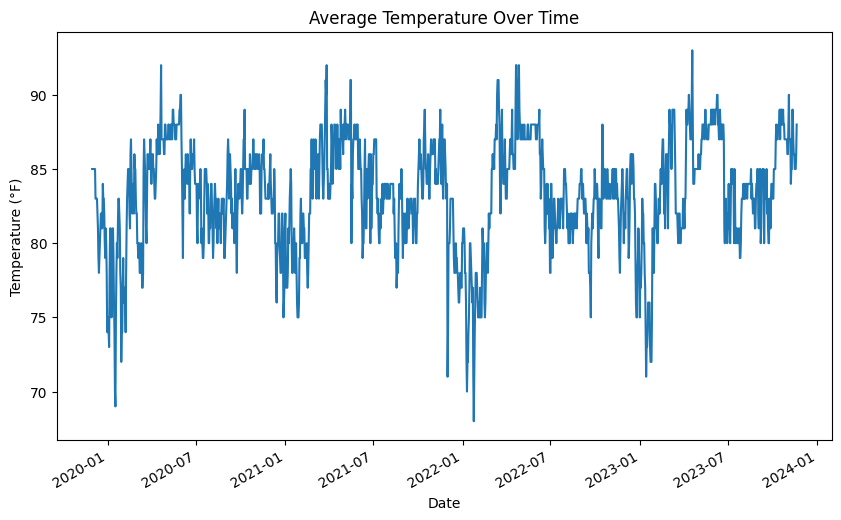

In [ ]:
import matplotlib.pyplot as plt
weather["tavg"].plot(figsize=(10, 6), title="Average Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.show()


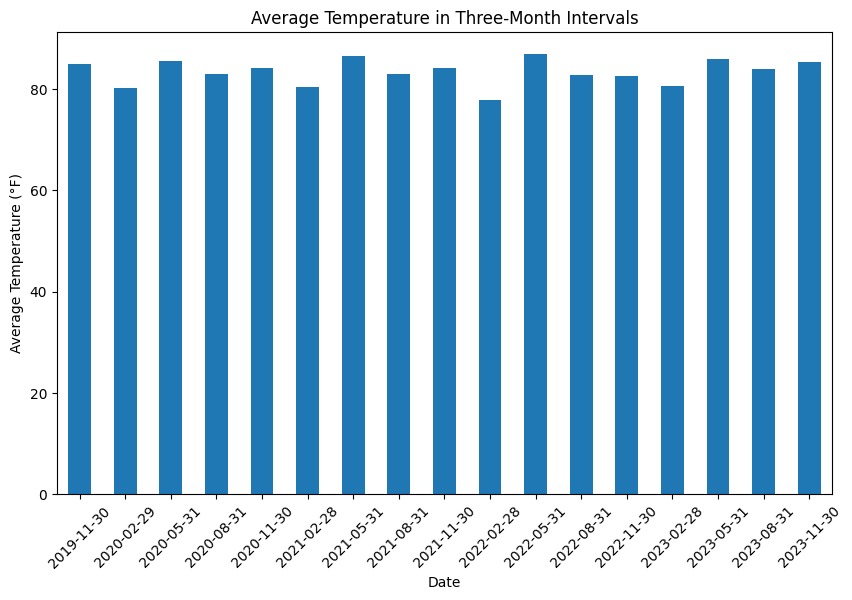

In [ ]:
weather.index = pd.to_datetime(weather.index)

# Resample data to get average temperature for each three-month interval
resampled_data = weather['tavg'].resample('3M').mean()

# Plot the bar graph
resampled_data.index = resampled_data.index.strftime('%Y-%m-%d')  # Format the index as date without time
resampled_data.plot(kind='bar', figsize=(10, 6), title="Average Temperature in Three-Month Intervals")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°F)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
year_2024 = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")
year_2024_df = pd.DataFrame(index=year_2024)

# Ensure the 'predictors' are available in the DataFrame
for predictor in predictors:
    year_2024_df[predictor] = 0  # You can fill with default values if needed

# Predict the temperatures for 2024
year_2024_df["predicted"] = rr.predict(year_2024_df[predictors])

# Display the table with only Date and Predicted Temperature
predictions_2024 = year_2024_df[["predicted"]]
predictions_2024.columns = ["Predicted Temperature"]

# Convert the index to a new column 'Date' for display
predictions_2024.reset_index(inplace=True)
predictions_2024.columns = ["Date", "      Predicted Temperature"]

# Display the table
print(predictions_2024)

          Date        Predicted Temperature
0   2024-01-01                     8.061534
1   2024-01-02                     8.061534
2   2024-01-03                     8.061534
3   2024-01-04                     8.061534
4   2024-01-05                     8.061534
..         ...                          ...
361 2024-12-27                     8.061534
362 2024-12-28                     8.061534
363 2024-12-29                     8.061534
364 2024-12-30                     8.061534
365 2024-12-31                     8.061534

[366 rows x 2 columns]
